In [142]:
import numpy as np
X_test = np.load("/u/home/s/sperrott/project-hugowill/project-sperrott/project/X_test.npy")
y_test = np.load("/u/home/s/sperrott/project-hugowill/project-sperrott/project/y_test.npy")
person_train_valid = np.load("/u/home/s/sperrott/project-hugowill/project-sperrott/project/person_train_valid.npy")
X_train_valid = np.load("/u/home/s/sperrott/project-hugowill/project-sperrott/project/X_train_valid.npy")
y_train_valid = np.load("/u/home/s/sperrott/project-hugowill/project-sperrott/project/y_train_valid.npy")
person_test = np.load("/u/home/s/sperrott/project-hugowill/project-sperrott/project/person_test.npy")

In [143]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [144]:
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

# Adjusting the labels
y_train_valid -= 769
y_test -= 769

In [145]:
# To ensure no data leakage
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=42)

In [146]:
def train_data_prep(X,y,sub_sample,average,noise):
    total_X = None
    total_y = None
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:550]
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    total_y = y
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
    return total_X,total_y

In [147]:
def preprocess_data(X, y=None, sub_sample=2, average=2, noise_level=0.5, apply_noise=True):
    X = X[:,:,0:550]  # (sample, 22, 800)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    if apply_noise:
        # Add noise to the training data
        X_max += np.random.normal(0.0, noise_level, X_max.shape)
        # If labels are provided, replicate them for augmented data
        if y is not None:
            y = np.tile(y, sub_sample)
    return X_max, y

In [148]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [149]:
def map_electrodes_to_grid(X, grid_size=(7, 7)):
    X_grid = np.zeros((X.shape[0], grid_size[0], grid_size[1], X.shape[1]))
    
    mappings = {
        7: (0, 0), 14: (2, 0), 19: (4, 0), 22: (6, 0),
        8: (1, 1), 15: (3, 1), 20: (5, 0),
        2: (0, 2), 9: (2, 2), 16: (4, 2), 21: (6, 2),
        3: (1, 3), 10: (3, 3), 17: (5, 3),
        4: (2, 4), 11: (4, 4), 18: (6, 4),
        1: (1, 5), 5: (3, 5), 12: (5, 5),
        6: (4, 6), 13: (6, 6)
    }
    
    for sample_index in range(X.shape[0]):
        for electrode_index in range(X.shape[2]):
            grid_pos = mappings.get(electrode_index - 1)
            if grid_pos:  # If the electrode has a mapped position
                # Place the electrode's time series data in the correct grid position.
                X_grid[sample_index, grid_pos[0], grid_pos[1], :] = X[sample_index, :, electrode_index - 1]
    
    return X_grid


In [150]:
X_test_prep, _ = preprocess_data(X_test, sub_sample=2, average=2, noise_level=0.5, apply_noise=False)
y_test_prep = tf.keras.utils.to_categorical(y_test, 4)

# Preprocess the training and validation data
X_train_prep, y_train_prep = train_data_prep(X_train,y_train,2,2,True)
X_valid_prep, y_valid_prep = preprocess_data(X_valid, y_valid, apply_noise=False)

# One-hot encode the labels
y_train_prep = tf.keras.utils.to_categorical(y_train_prep, 4)
y_valid_prep = tf.keras.utils.to_categorical(y_valid_prep, 4)

X_train_prep = np.swapaxes(X_train_prep, 1, 2)
X_valid_prep = np.swapaxes(X_valid_prep, 1, 2)
X_test_prep = np.swapaxes(X_test_prep, 1, 2)

X_train_prep = map_electrodes_to_grid(X_train_prep)
X_valid_prep = map_electrodes_to_grid(X_valid_prep)
X_test_prep = map_electrodes_to_grid(X_test_prep)

# Adding the channel dimension
X_train_prep = X_train_prep.reshape((-1, 7, 7, 275, 1))
X_valid_prep = X_valid_prep.reshape((-1, 7, 7, 275, 1))
X_test_prep = X_test_prep.reshape((-1, 7, 7, 275, 1))

print('Shape of training set:', X_train_prep.shape)
print('Shape of training labels:',y_train_prep.shape)
print('Shape of validation set:', X_valid_prep.shape)
print('Shape of validation labels:',y_valid_prep.shape)
print('Shape of test set:', X_test_prep.shape)
print('Shape of test labels after categorical conversion:', y_test_prep.shape)


Shape of training set: (7612, 7, 7, 275, 1)
Shape of training labels: (7612, 4)
Shape of validation set: (212, 7, 7, 275, 1)
Shape of validation labels: (212, 4)
Shape of test set: (443, 7, 7, 275, 1)
Shape of test labels after categorical conversion: (443, 4)


In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, BatchNormalization, MaxPooling3D, Dropout, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, MaxPooling1D, GRU, Conv1D, Reshape, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [152]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv3D(filters=10, kernel_size=(2,2,5), padding='same', activation='relu', input_shape=(7, 7, 275, 1), kernel_regularizer=l2(0.001)))
hybrid_cnn_lstm_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv3D(filters=10, kernel_size=(2,2,5), padding='same', activation='relu', dilation_rate=2, kernel_regularizer=l2(0.001))) # 50
hybrid_cnn_lstm_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv3D(filters=10, kernel_size=(2,2,5), padding='same', activation='relu', dilation_rate=4, kernel_regularizer=l2(0.001))) # 100
hybrid_cnn_lstm_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv3D(filters=10, kernel_size=(2,2,5), padding='same', activation='relu', dilation_rate=8, kernel_regularizer=l2(0.001))) # 200
hybrid_cnn_lstm_model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(GRU(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 7, 7, 275, 10)     210       
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 4, 4, 138, 10)    0         
 g3D)                                                            
                                                                 
 batch_normalization_313 (Ba  (None, 4, 4, 138, 10)    40        
 tchNormalization)                                               
                                                                 
 dropout_311 (Dropout)       (None, 4, 4, 138, 10)     0         
                                                                 
 conv3d_21 (Conv3D)          (None, 4, 4, 138, 10)     2010      
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 2, 2, 69, 10)   

In [153]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [154]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(X_train_prep,
             y_train_prep,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid_prep, y_valid_prep), verbose=True)

Epoch 1/100
119/119 [==============================] - 17s 127ms/step - loss: 1.3961 - accuracy: 0.2488 - val_loss: 1.3865 - val_accuracy: 0.2642
Epoch 2/100
119/119 [==============================] - 14s 118ms/step - loss: 1.3866 - accuracy: 0.2504 - val_loss: 1.3855 - val_accuracy: 0.2642
Epoch 3/100
119/119 [==============================] - 13s 110ms/step - loss: 1.3865 - accuracy: 0.2559 - val_loss: 1.3855 - val_accuracy: 0.2642
Epoch 4/100
119/119 [==============================] - 13s 111ms/step - loss: 1.3864 - accuracy: 0.2549 - val_loss: 1.3867 - val_accuracy: 0.2642
Epoch 5/100
119/119 [==============================] - 13s 109ms/step - loss: 1.3863 - accuracy: 0.2534 - val_loss: 1.3850 - val_accuracy: 0.2453
Epoch 6/100
119/119 [==============================] - 13s 108ms/step - loss: 1.3865 - accuracy: 0.2516 - val_loss: 1.3856 - val_accuracy: 0.2642
Epoch 7/100
119/119 [==============================] - 14s 119ms/step - loss: 1.3864 - accuracy: 0.2520 - val_loss: 1.3856 -

KeyboardInterrupt: 

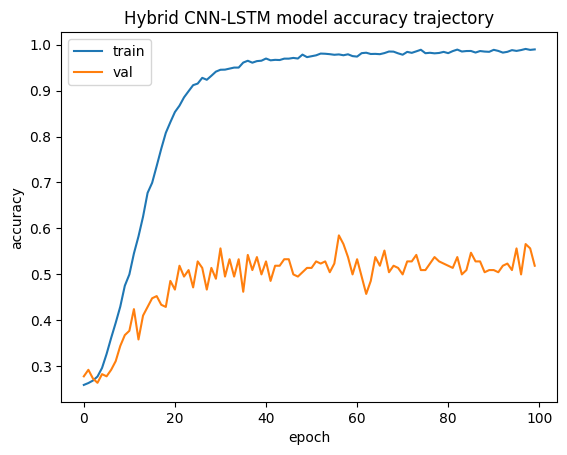

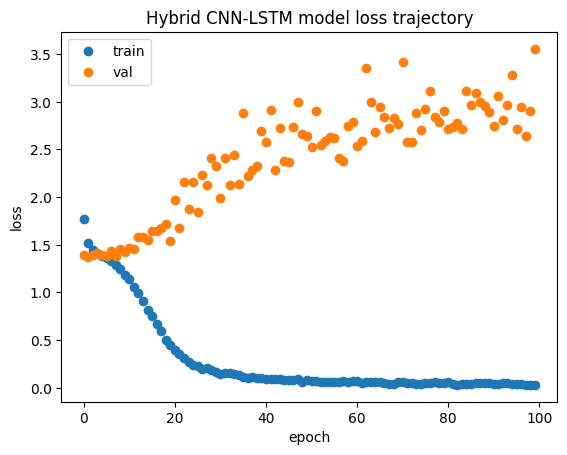

In [84]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [85]:
## Testing the hybrid CNN-LSTM model

score = model.evaluate(X_test_prep, y_test_prep, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.5237020254135132
